In [39]:
import pandas as pd

df = pd.read_csv('../data/processed/cleaned_data.csv')

In [40]:
df['Adj_Close_Change'] = df.groupby('Company')['Close/Last'].pct_change() * 100
df['Volume_Change'] = df.groupby('Company')['Volume'].pct_change() * 100

df = df.dropna(subset=['Adj_Close_Change', 'Volume_Change'])

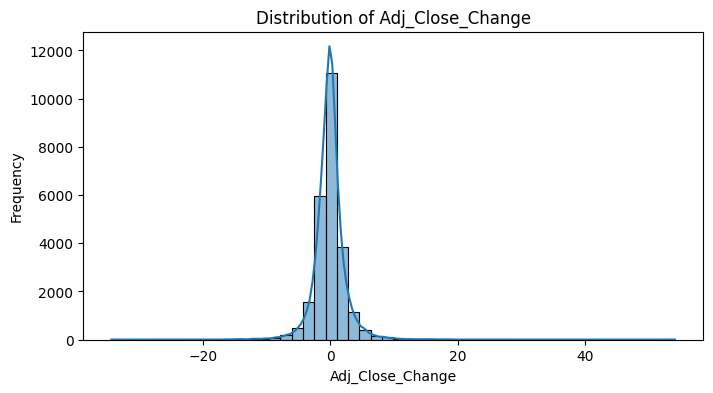

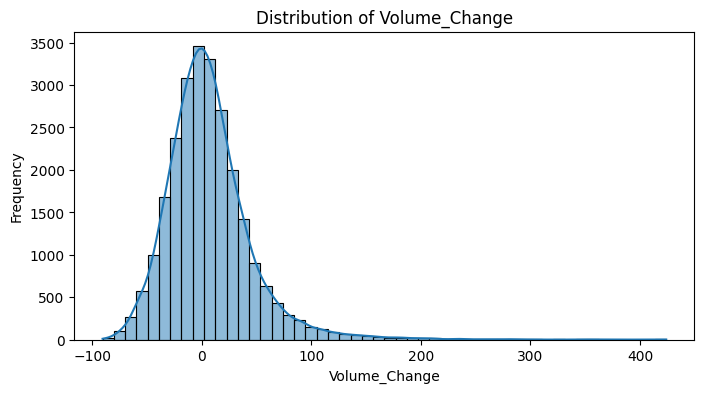

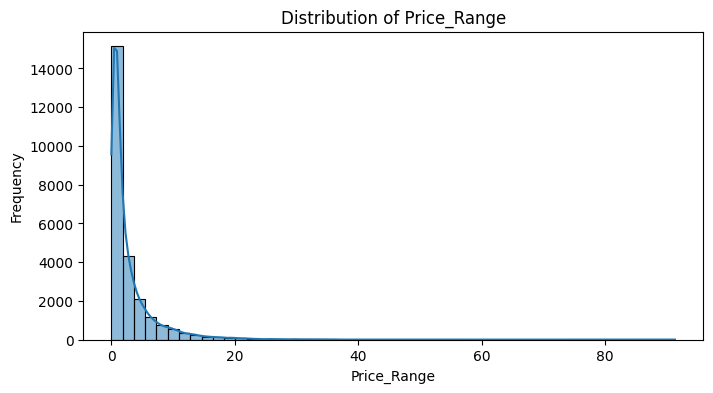

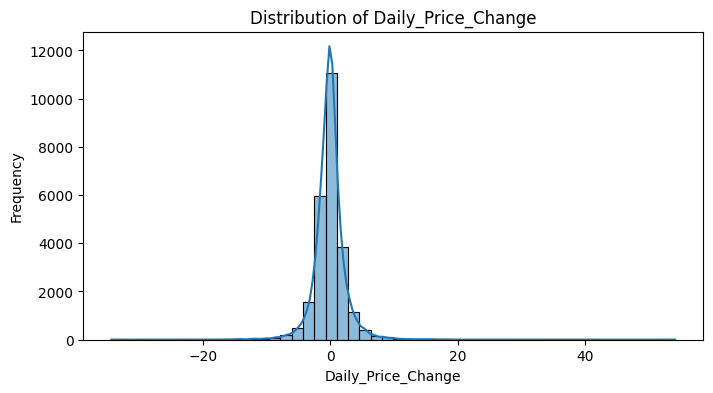

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_features = ['Adj_Close_Change', 'Volume_Change', 'Price_Range', 'Daily_Price_Change']

for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


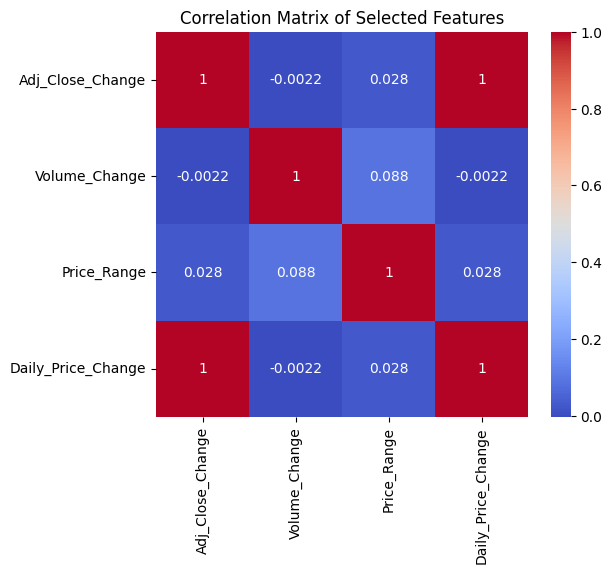

In [42]:
corr_matrix = df[selected_features].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()


In [43]:
# Drop rows with missing values in selected features
df_model = df.dropna(subset=selected_features)

# Extract features and target
X = df_model[selected_features]


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [45]:
from sklearn.ensemble import IsolationForest

# Initialize the model
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(X_scaled)

# Predict anomalies (-1 for anomalies, 1 for normal)
df_model['IF_Pred'] = iso_forest.predict(X_scaled)
df_model['IF_Anomaly'] = df_model['IF_Pred'].apply(lambda x: 1 if x == -1 else 0)

# Count anomalies
num_anomalies_if = df_model['IF_Anomaly'].sum()
print(f"Isolation Forest detected {num_anomalies_if} anomalies out of {len(df_model)} samples.")


Isolation Forest detected 252 anomalies out of 25150 samples.


In [46]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict anomalies
y_pred_lof = lof.fit_predict(X_scaled)
df_model['LOF_Anomaly'] = [1 if x == -1 else 0 for x in y_pred_lof]

# Count anomalies
num_anomalies_lof = df_model['LOF_Anomaly'].sum()
print(f"LOF detected {num_anomalies_lof} anomalies out of {len(df_model)} samples.")


LOF detected 252 anomalies out of 25150 samples.


In [47]:
# Create a comparison column
df_model['Anomaly_Comparison'] = df_model.apply(
    lambda row: 'Both' if row['IF_Anomaly'] == 1 and row['LOF_Anomaly'] == 1
    else ('Isolation Forest' if row['IF_Anomaly'] == 1 else ('LOF' if row['LOF_Anomaly'] == 1 else 'None')),
    axis=1
)

# Count the occurrences
comparison_counts = df_model['Anomaly_Comparison'].value_counts()
print(comparison_counts)


Anomaly_Comparison
None                24732
LOF                   166
Isolation Forest      166
Both                   86
Name: count, dtype: int64


In [48]:
# Companies with anomalies detected by both models
companies_with_both_anomalies = df_model[df_model['Anomaly_Comparison'] == 'Both']['Company'].unique()
print("Companies with anomalies detected by both models:")
print(companies_with_both_anomalies)


Companies with anomalies detected by both models:
['SBUX' 'MSFT' 'CSCO' 'QCOM' 'META' 'TSLA' 'AMD' 'NFLX']


In [54]:
from sklearn.cluster import DBSCAN

# Scale features are already prepared
# Determine appropriate eps and min_samples values
dbscan = DBSCAN(eps=0.5, min_samples=5)


In [55]:
# Fit the model on the scaled features
dbscan.fit(X_scaled)

# Extract cluster labels (-1 indicates anomalies/noise)
df_model['DBSCAN_Label'] = dbscan.labels_

# Identify anomalies
df_model['DBSCAN_Anomaly'] = df_model['DBSCAN_Label'].apply(lambda x: 1 if x == -1 else 0)

# Number of anomalies detected
num_anomalies_dbscan = df_model['DBSCAN_Anomaly'].sum()
print(f"DBSCAN detected {num_anomalies_dbscan} anomalies out of {len(df_model)} samples.")


DBSCAN detected 461 anomalies out of 25150 samples.


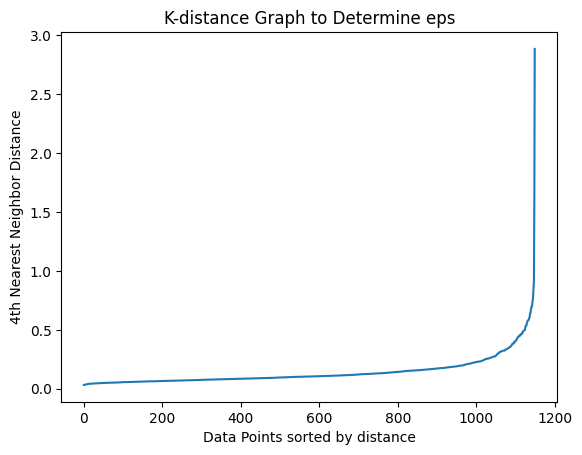

In [56]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Use NearestNeighbors to find the distances
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to find the "elbow" point
distances = np.sort(distances[24000:25200, 4], axis=0)
plt.plot(distances)
plt.title('K-distance Graph to Determine eps')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()


In [58]:
# List of anomaly detection columns
anomaly_columns = ['IF_Anomaly', 'LOF_Anomaly', 'DBSCAN_Anomaly']

# Option 1: Flag as anomaly if any model detects it
df_model['Ensemble_Anomaly'] = df_model[anomaly_columns].max(axis=1)

# Option 2: Flag as anomaly if at least two models detect it
df_model['Ensemble_Anomaly'] = df_model[anomaly_columns].sum(axis=1)
df_model['Ensemble_Anomaly'] = df_model['Ensemble_Anomaly'].apply(lambda x: 1 if x >= 2 else 0)


In [59]:
# Number of anomalies detected by the ensemble
num_anomalies_ensemble = df_model['Ensemble_Anomaly'].sum()
print(f"Ensemble model detected {num_anomalies_ensemble} anomalies out of {len(df_model)} samples.")


Ensemble model detected 277 anomalies out of 25150 samples.


In [60]:
# Isolation Forest anomalies
anomalies_if = df_model[df_model['IF_Anomaly'] == 1]
anomaly_dates_if = anomalies_if[['Date', 'Company']].drop_duplicates().sort_values('Date')

print("Isolation Forest Anomaly Dates:")
print(anomaly_dates_if)


Isolation Forest Anomaly Dates:
             Date Company
7547   2013-07-18    MSFT
22643  2013-07-18     AMD
15091  2013-07-24    META
22579  2013-10-17     AMD
25093  2013-10-21    NFLX
...           ...     ...
17672  2023-04-19    TSLA
12635  2023-04-26    META
2567   2023-05-02    SBUX
22684  2023-05-17    NFLX
22683  2023-05-18    NFLX

[252 rows x 2 columns]


In [61]:
# LOF anomalies
anomalies_lof = df_model[df_model['LOF_Anomaly'] == 1]
anomaly_dates_lof = anomalies_lof[['Date', 'Company']].drop_duplicates().sort_values('Date')

print("LOF Anomaly Dates:")
print(anomaly_dates_lof)


LOF Anomaly Dates:
             Date Company
22642  2013-07-19     AMD
7546   2013-07-19    MSFT
15091  2013-07-24    META
7522   2013-08-22    MSFT
22599  2013-09-19     AMD
...           ...     ...
22671  2023-06-06    NFLX
22670  2023-06-07    NFLX
22669  2023-06-08    NFLX
12595  2023-06-23    META
12589  2023-07-03    META

[252 rows x 2 columns]


In [62]:
# DBSCAN anomalies
anomalies_dbscan = df_model[df_model['DBSCAN_Anomaly'] == 1]
anomaly_dates_dbscan = anomalies_dbscan[['Date', 'Company']].drop_duplicates().sort_values('Date')

print("DBSCAN Anomaly Dates:")
print(anomaly_dates_dbscan)


DBSCAN Anomaly Dates:
             Date Company
7547   2013-07-18    MSFT
22642  2013-07-19     AMD
7546   2013-07-19    MSFT
25156  2013-07-23    NFLX
15091  2013-07-24    META
...           ...     ...
22683  2023-05-18    NFLX
22677  2023-05-26    NFLX
22670  2023-06-07    NFLX
22663  2023-06-16    NFLX
12595  2023-06-23    META

[461 rows x 2 columns]


In [94]:
# Anomalies detected by all models
anomalies_all = anomalies_if.merge(anomalies_lof, on=['Date', 'Company'])
anomalies_all = anomalies_all.merge(anomalies_dbscan, on=['Date', 'Company'])

# Extract and sort unique dates
anomaly_dates = anomalies_all[['Date']].drop_duplicates().sort_values('Date')

print("Anomaly Dates Detected by All Models:")
print(anomaly_dates)


Anomaly Dates Detected by All Models:
          Date
16  2013-07-24
84  2014-10-15
49  2015-02-05
48  2015-06-26
83  2015-08-24
..         ...
52  2022-10-18
9   2022-10-26
8   2023-02-01
51  2023-05-17
50  2023-05-18

[74 rows x 1 columns]


## **Analyze anomaly date for seasonality**

In [84]:
# Convert 'Date' to datetime if not already done
anomaly_dates['Date'] = pd.to_datetime(anomaly_dates['Date'])

# Extract month and year
anomaly_dates['Month'] = anomaly_dates['Date'].dt.month
anomaly_dates['Year'] = anomaly_dates['Date'].dt.year

# Map month numbers to month names (optional)
anomaly_dates['Month_Name'] = anomaly_dates['Date'].dt.strftime('%B')

print(anomaly_dates.head())


         Date  Month  Year Month_Name
16 2013-07-24      7  2013       July
84 2014-10-15     10  2014    October
49 2015-02-05      2  2015   February
48 2015-06-26      6  2015       June
83 2015-08-24      8  2015     August


In [86]:
# Count anomalies per month across all years
monthly_anomalies = anomaly_dates.groupby('Month_Name').size().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])

print("Number of Anomalies per Month:")
print(monthly_anomalies)


Number of Anomalies per Month:
Month_Name
January      11
February      7
March        11
April        10
May           4
June          2
July          7
August        2
September     5
October       9
November      3
December      3
dtype: int64


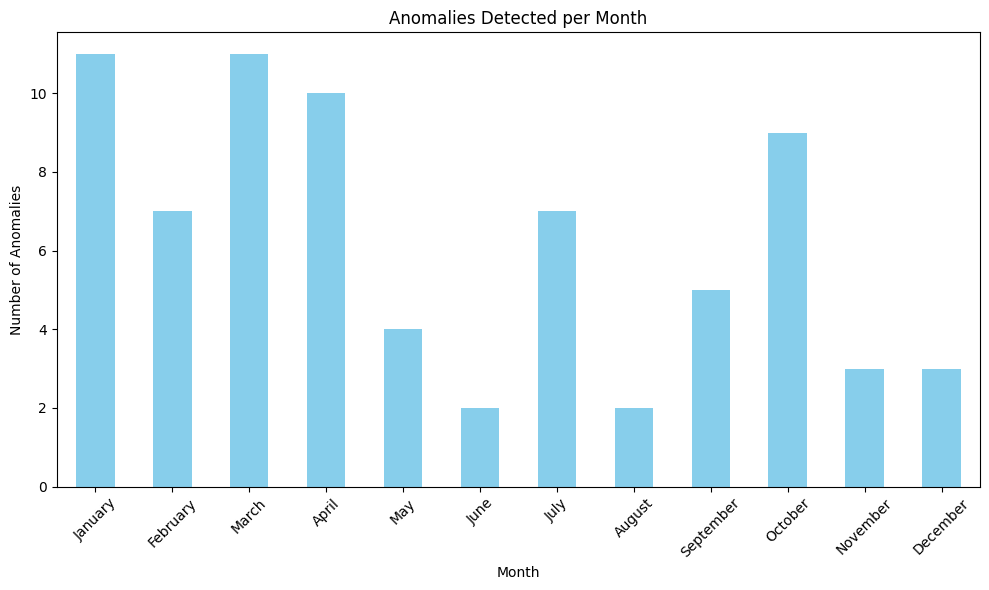

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
monthly_anomalies.plot(kind='bar', color='skyblue')
plt.title('Anomalies Detected per Month')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Number of Anomalies per Year:
Year
2013     1
2014     1
2015     4
2016     3
2017     1
2018     9
2019     4
2020    16
2021    13
2022    19
2023     3
dtype: int64


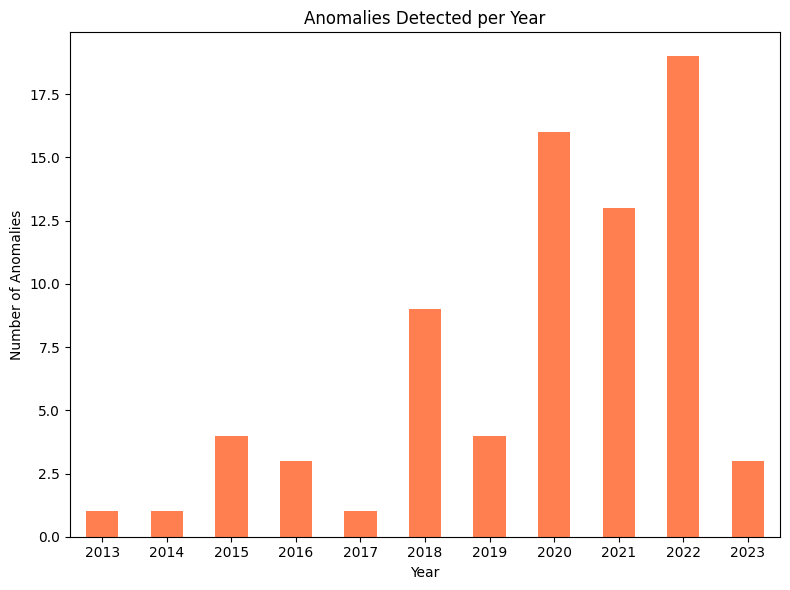

In [88]:
# Count anomalies per year
yearly_anomalies = anomaly_dates.groupby('Year').size()

print("Number of Anomalies per Year:")
print(yearly_anomalies)

# Plot anomalies per year
plt.figure(figsize=(8, 6))
yearly_anomalies.plot(kind='bar', color='coral')
plt.title('Anomalies Detected per Year')
plt.xlabel('Year')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


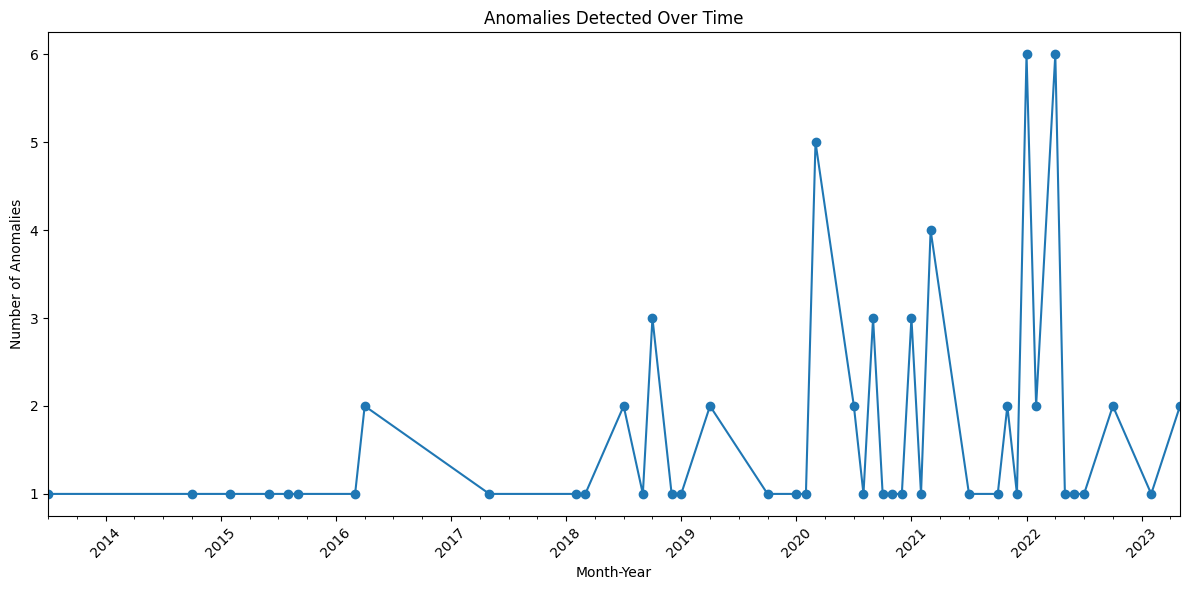

In [89]:
# Create a Month-Year column
anomaly_dates['Month_Year'] = anomaly_dates['Date'].dt.to_period('M')

# Count anomalies per Month-Year
monthly_yearly_anomalies = anomaly_dates.groupby('Month_Year').size()

# Plot anomalies over time
plt.figure(figsize=(12, 6))
monthly_yearly_anomalies.plot(kind='line', marker='o')
plt.title('Anomalies Detected Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Analyzing Duplicate Dates

In [90]:
# Count occurrences of each date
date_counts = anomalies_all.groupby('Date').size().reset_index(name='Count')

# Filter for dates with more than one occurrence (duplicates)
duplicate_dates = date_counts[date_counts['Count'] > 1]

print("Dates with Multiple Anomalies Detected:")
print(duplicate_dates)


Dates with Multiple Anomalies Detected:
          Date  Count
27  2020-03-12      2
28  2020-03-13      7
32  2020-08-26      2
34  2020-09-04      2
55  2022-01-26      2
59  2022-02-02      2


In [91]:
# Filter anomalies_all for duplicate dates
duplicate_anomalies = anomalies_all[anomalies_all['Date'].isin(duplicate_dates['Date'])]

print("Companies Behind Duplicate Dates:")
print(duplicate_anomalies.sort_values('Date'))


Companies Behind Duplicate Dates:
   Company        Date  Close/Last_x   Volume_x     Open_x     High_x  \
14    META  2020-03-12      154.4700   43266340    $159.54    $166.60   
2     MSFT  2020-03-12      139.0600   93226370    $145.30    $153.47   
36    TSLA  2020-03-13       36.4414  339603580   $39.6667   $40.5047   
13    META  2020-03-13      170.2800   35028630    $163.53    $170.79   
0     SBUX  2020-03-13       69.9200   19247180     $65.65     $70.18   
3     CSCO  2020-03-13       37.6400   53859600     $35.18     $37.68   
1     MSFT  2020-03-13      158.8300   92727450    $147.50    $161.91   
5     QCOM  2020-03-13       75.8100   15971420     $71.18     $76.67   
74    NFLX  2020-03-13      336.2950    9458197    $330.51    $336.42   
12    META  2020-08-26      303.9100   69015150    $284.00    $304.67   
70    NFLX  2020-08-26      547.5300   20373680    $492.50    $549.04   
34    TSLA  2020-09-04      139.4400  330965733    $134.27  $142.6667   
69    NFLX  2020-

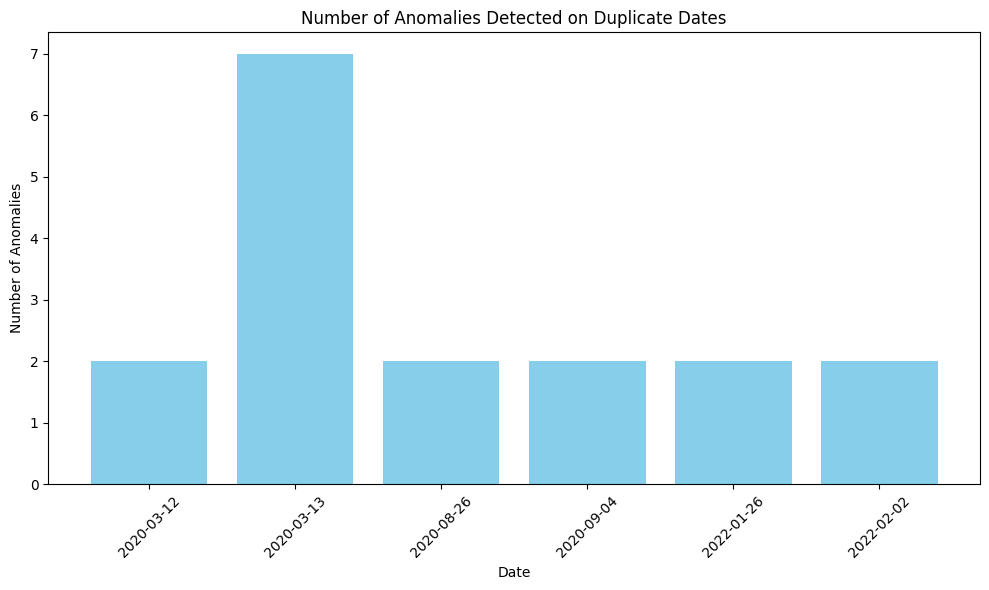

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(duplicate_dates['Date'].astype(str), duplicate_dates['Count'], color='skyblue')
plt.title('Number of Anomalies Detected on Duplicate Dates')
plt.xlabel('Date')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Plots Showing Anomaly Distribution Around Clusters**

In [64]:
from sklearn.decomposition import PCA

# Features used for modeling
features = df_model[selected_features]

# Scale features if not already scaled
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'IF_Anomaly': df_model['IF_Anomaly'],
    'LOF_Anomaly': df_model['LOF_Anomaly'],
    'DBSCAN_Anomaly': df_model['DBSCAN_Anomaly'],
    'Company': df_model['Company'],
    'Date': df_model['Date']
})


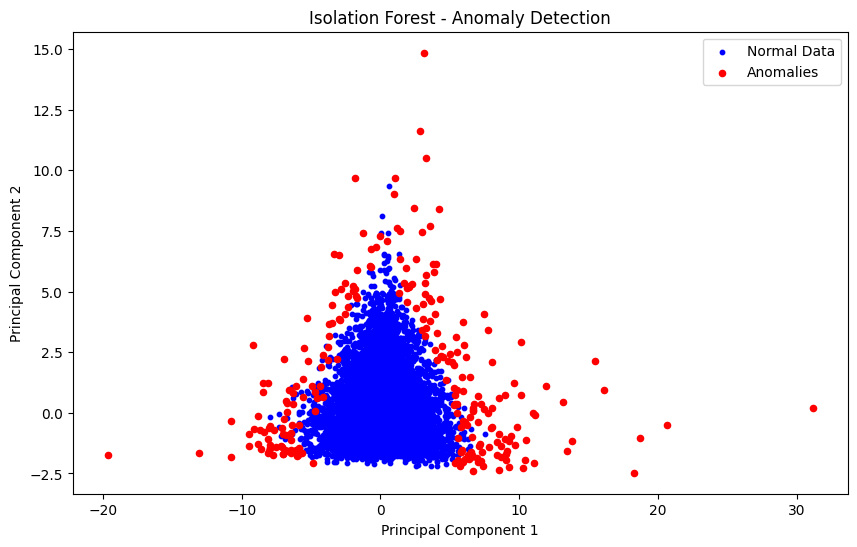

In [65]:
import matplotlib.pyplot as plt

# Normal data points
normal_data = plot_df[plot_df['IF_Anomaly'] == 0]
anomaly_data = plot_df[plot_df['IF_Anomaly'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data['PCA1'], normal_data['PCA2'], c='blue', s=10, label='Normal Data')
plt.scatter(anomaly_data['PCA1'], anomaly_data['PCA2'], c='red', s=20, label='Anomalies')
plt.title('Isolation Forest - Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


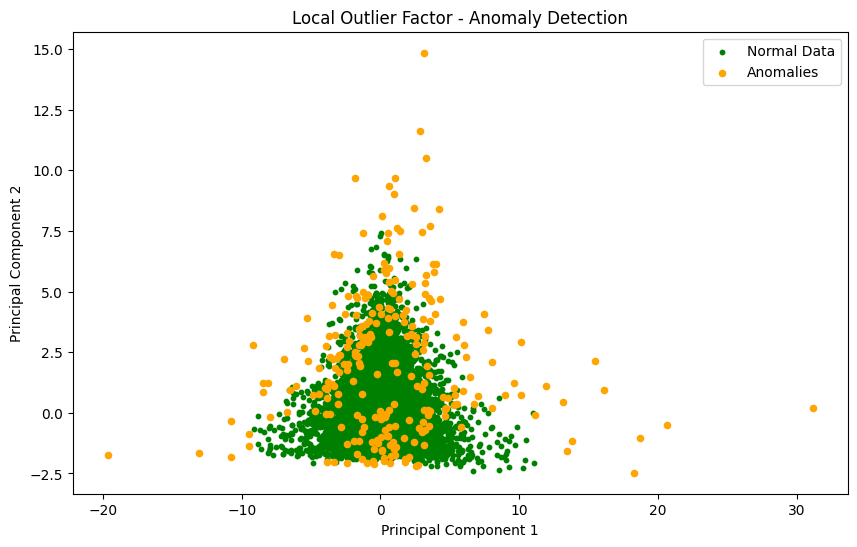

In [66]:
# Normal data points
normal_data = plot_df[plot_df['LOF_Anomaly'] == 0]
anomaly_data = plot_df[plot_df['LOF_Anomaly'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data['PCA1'], normal_data['PCA2'], c='green', s=10, label='Normal Data')
plt.scatter(anomaly_data['PCA1'], anomaly_data['PCA2'], c='orange', s=20, label='Anomalies')
plt.title('Local Outlier Factor - Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


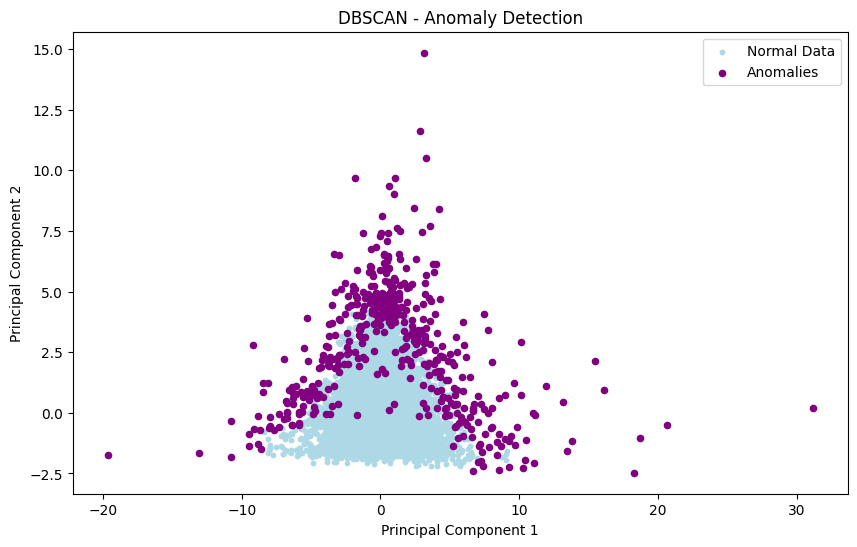

In [67]:
# Normal data points
normal_data = plot_df[plot_df['DBSCAN_Anomaly'] == 0]
anomaly_data = plot_df[plot_df['DBSCAN_Anomaly'] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(normal_data['PCA1'], normal_data['PCA2'], c='lightblue', s=10, label='Normal Data')
plt.scatter(anomaly_data['PCA1'], anomaly_data['PCA2'], c='purple', s=20, label='Anomalies')
plt.title('DBSCAN - Anomaly Detection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


## **Feature Distributions Visualization**

In [68]:
# Separate anomalies and normal data for statistical analysis
anomalies = df_model[df_model['Ensemble_Anomaly'] == 1][selected_features]
normal_data = df_model[df_model['Ensemble_Anomaly'] == 0][selected_features]


/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(normal_data[feature], label='Normal Data', shade=True)
/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(anomalies[feature], label='Anomalies', shade=True)


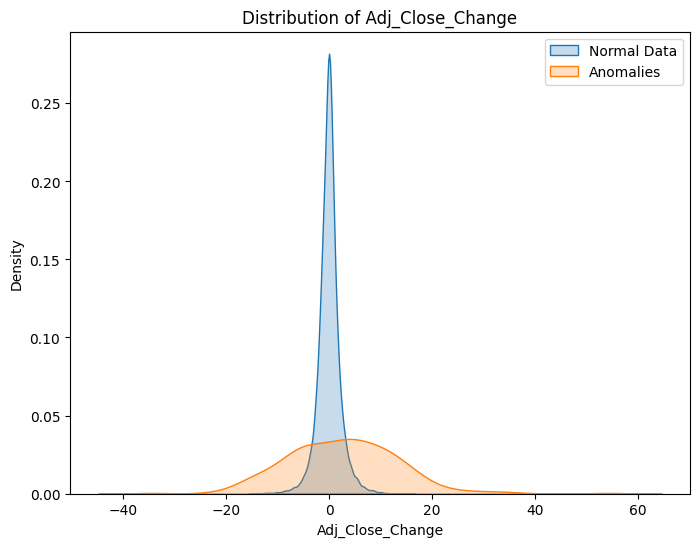

/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(normal_data[feature], label='Normal Data', shade=True)
/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(anomalies[feature], label='Anomalies', shade=True)


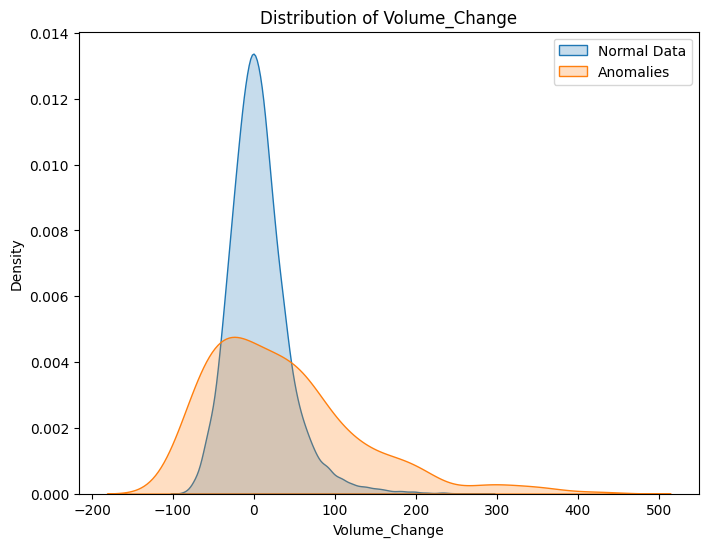

/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(normal_data[feature], label='Normal Data', shade=True)
/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(anomalies[feature], label='Anomalies', shade=True)


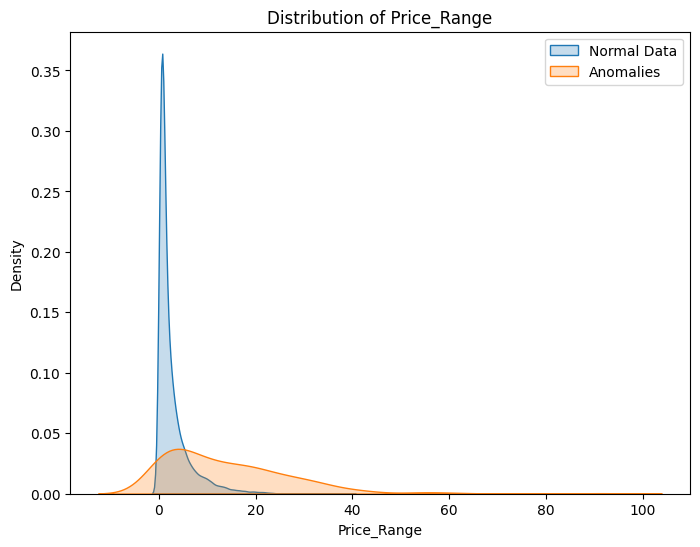

/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(normal_data[feature], label='Normal Data', shade=True)
/var/folders/hl/n8ld50fn44bgmz1x9g35k1800000gn/T/ipykernel_68605/892733214.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(anomalies[feature], label='Anomalies', shade=True)


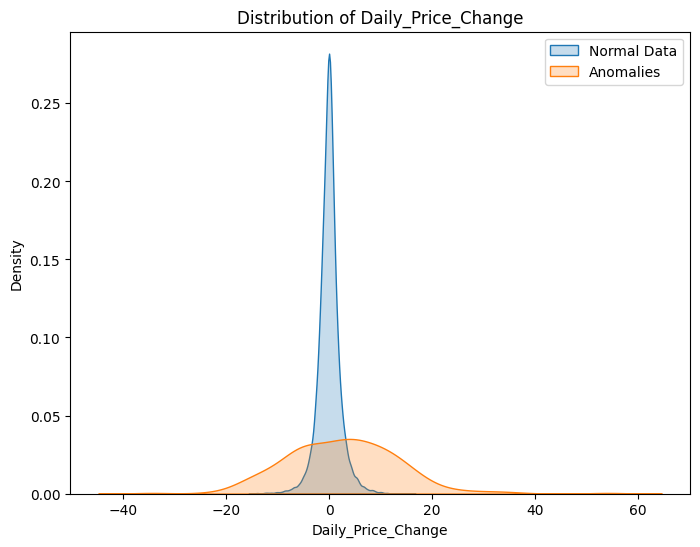

In [69]:
t


In [78]:
from scipy.stats import ttest_ind

for feature in selected_features:
    stat, p_value = ttest_ind(anomalies[feature], normal_data[feature], equal_var=False)
    print(f"{feature}: t-statistic = {stat:.2f}, p-value = {p_value:.100f}")


Adj_Close_Change: t-statistic = 4.00, p-value = 0.0000826054993239643502297639421350083921424811705946922302246093750000000000000000000000000000000000
Volume_Change: t-statistic = 5.18, p-value = 0.0000004255010873764042538239975917851998232777077646460384130477905273437500000000000000000000000000
Price_Range: t-statistic = 14.44, p-value = 0.0000000000000000000000000000000000128790047800607347504590559139210984113933254119214081001968168672
Daily_Price_Change: t-statistic = 4.00, p-value = 0.0000826054993239643502297639421350083921424811705946922302246093750000000000000000000000000000000000


In [79]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(anomalies['Price_Range'], normal_data['Price_Range'], equal_var=False)
print(f"Price_Range: t-statistic = {stat:.2f}, p-value = {p_value:.10f}")


Price_Range: t-statistic = 14.44, p-value = 0.0000000000


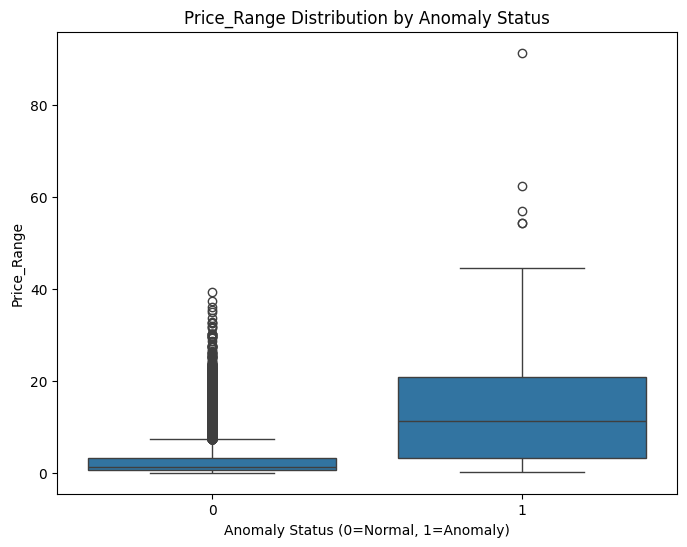

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='Ensemble_Anomaly', y='Price_Range', data=df_model)
plt.title('Price_Range Distribution by Anomaly Status')
plt.xlabel('Anomaly Status (0=Normal, 1=Anomaly)')
plt.ylabel('Price_Range')
plt.show()


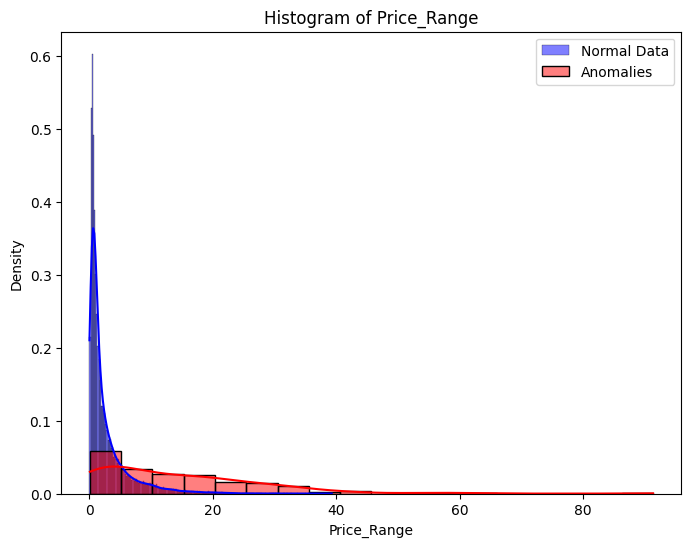

In [81]:
plt.figure(figsize=(8, 6))
sns.histplot(normal_data['Price_Range'], label='Normal Data', color='blue', kde=True, stat='density')
sns.histplot(anomalies['Price_Range'], label='Anomalies', color='red', kde=True, stat='density')
plt.title('Histogram of Price_Range')
plt.xlabel('Price_Range')
plt.ylabel('Density')
plt.legend()
plt.show()


In [82]:
import numpy as np

mean_diff = anomalies['Price_Range'].mean() - normal_data['Price_Range'].mean()
pooled_std = np.sqrt(((anomalies['Price_Range'].std() ** 2) + (normal_data['Price_Range'].std() ** 2)) / 2)
cohen_d = mean_diff / pooled_std
print(f"Cohen's d for Price_Range: {cohen_d:.2f}")


Cohen's d for Price_Range: 1.18
